In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
 cd /content/drive/My\ Drive

/content/drive/My Drive


In [ ]:
cd AI\ VIET\ NAM/Tensorflow/Generatives/NeuralStyleTransfer

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
import imutils
from scipy.stats import pearsonr
import sys
import scipy 

In [ ]:
import numpy as np
from scipy.special import gamma,psi
from scipy import ndimage
from scipy.linalg import det
from numpy import pi
from sklearn.metrics import mutual_info_score
from sklearn.neighbors import NearestNeighbors

In [ ]:
#content_path = keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_path = content_path = "./images/123057.jpg"
style_path = keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


In [ ]:
style_path3 = "./images/test_style_image3.jpg"
style_path2 = tf.keras.utils.get_file('VG485-1000x1000.jpg','https://media.overstockart.com/optimized/cache/data/product_images/VG485-1000x1000.jpg')

237568/235722 [==============================] - 0s 0us/step


In [ ]:
import cv2 
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import PIL
import numpy as np

In [ ]:
content_image = cv2.imread(content_path)
style_image1 = cv2.imread(style_path)
style_image2 = cv2.imread(style_path2)
style_image3 = cv2.imread(style_path3)

In [ ]:
style_image1 = cv2.resize(style_image1, (content_image.shape[1], content_image.shape[0]))


In [ ]:
style_image2 = cv2.resize(style_image2, (content_image.shape[1], content_image.shape[0]))
style_image3 = cv2.resize(style_image3, (content_image.shape[1], content_image.shape[0]))

In [ ]:
#content_image = imutils.resize(content_image, width=512)

In [ ]:
content_image = content_image/255
style_image1 = style_image1/255
style_image2 = style_image2/255
style_image3 = style_image3/255

In [ ]:
style_image3.shape

(321, 481, 3)

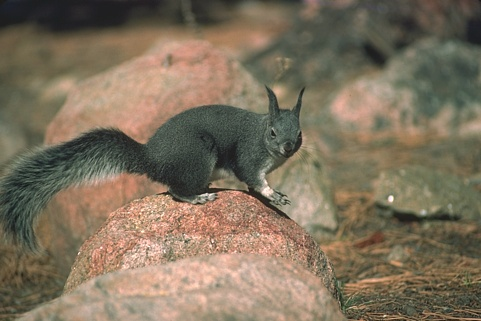

In [ ]:
cv2_imshow(content_image*255)

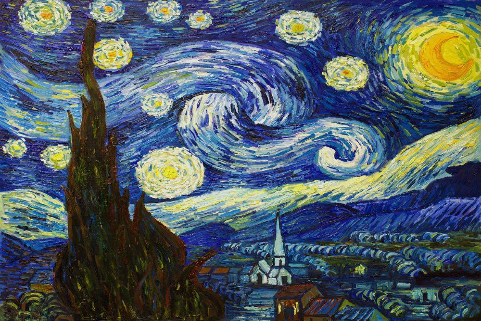

In [ ]:
cv2_imshow(style_image2*255.0)

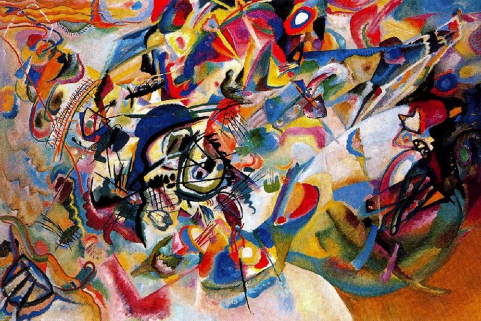

In [ ]:
cv2_imshow(style_image1*255)

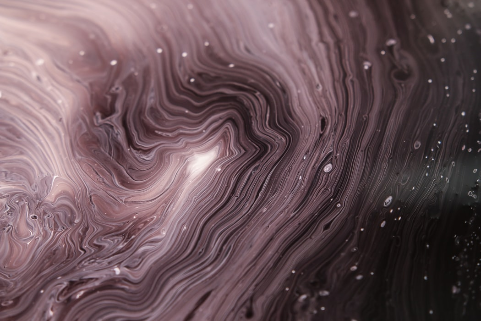

In [ ]:
cv2_imshow(style_image3*255)

In [ ]:
content_image = tf.cast(content_image, dtype=tf.float32)
style_image1 = tf.cast(style_image1, dtype=tf.float32)
style_image2 = tf.cast(style_image2, dtype=tf.float32)
style_image3 = tf.cast(style_image3, dtype=tf.float32)

In [ ]:
content_image = tf.expand_dims(content_image, axis=0)
style_image1 = tf.expand_dims(style_image1, axis=0)
style_image2 = tf.expand_dims(style_image2, axis=0)
style_image3 = tf.expand_dims(style_image3, axis=0)

In [ ]:
style_images = [style_image1, style_image2,style_image3]

In [ ]:
content_layers = ['block5_conv2']
style_layers = ["block1_conv1","block2_conv1", "block3_conv1", "block4_conv1", 'block5_conv1']

In [ ]:

def gram_matrix(input_tensor):
  # np.random.seed(0)
  # b,h,w,c = input_tensor.shape
  # input_tensor = tf.reshape(input_tensor, (b,-1,c))
  # input_tensor = input_tensor.numpy()[0]
  # np.take(input_tensor,np.random.permutation(input_tensor.shape[1]),axis=1,out=input_tensor)
  # input_tensor = tf.reshape(input_tensor, (b,h,w,c))
  
  temp = tf.linalg.einsum("bijc, bijd -> bcd", input_tensor, input_tensor)
  shape = tf.shape(input_tensor)
  num_locations = tf.cast(shape[1] * shape[2], tf.float32)
  return temp / num_locations

In [ ]:
def pearsonr_matrix(input_tensor):
  input_shape = input_tensor.shape
  mean = []
  std = []
  for i in range(input_shape[0]):
    for j in range(input_shape[3]):
      mean.append(tf.math.reduce_mean(input_tensor[i,:,:,j]))
      std.append(tf.math.reduce_std(input_tensor[i,:,:,j]) + 1e-8)
  temp = ((input_tensor - mean)/(std))
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)


  result = tf.linalg.einsum("bijc,bijd -> bcd", temp, temp)
  return result
  

In [ ]:
def cov_matrix(input_tensor):
  input_shape = input_tensor.shape
  mean = []
  for i in range(input_shape[0]):
    for j in range(input_shape[3]):
      mean.append(tf.math.reduce_mean(input_tensor[i,:,:,j]))
      #std.append(tf.math.reduce_std(input_tensor[i,:,:,j]) + 1e-8)
  temp = (input_tensor - mean)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

  result = tf.linalg.einsum("bijc,bijd -> bcd", temp, temp)
  return result/num_locations

In [ ]:
def euclidean_matrix(input_tensor):
  b,h,w,c = input_tensor.shape
  feature_map = tf.reshape(input_tensor,(b,-1,c))     
  G = tf.einsum('bic, bid->bcd', feature_map, feature_map)
  D = tf.reshape(tf.linalg.diag_part(G),(b,-1,1))+ tf.transpose(tf.reshape(tf.linalg.diag_part(G),(b,-1,1)),perm=(0,2,1)) - 2*G
  result = tf.sqrt(D)
  
  result = tf.reshape(result, [b,c,c])
  return result


In [ ]:
def cosine_sim(input_tensor):
  input_shape = input_tensor.shape
  norm = []
  for i in range(input_shape[0]):
    for j in range(input_shape[3]):
      norm.append(tf.norm(input_tensor[i,:,:,j]) + 1e-8 )
      #std.append(tf.math.reduce_std(input_tensor[i,:,:,j]) + 1e-8)
  temp = (input_tensor/norm)
  result = tf.linalg.einsum("bijc,bijd -> bcd", temp, temp)
  return result


In [ ]:
def vgg_layers(layer_names):
  vgg = VGG19(include_top=False, weights="imagenet")
  vgg.trainable= False
  outputs = [vgg.get_layer(name).output for name in layer_names]

  return Model([vgg.input], outputs)


In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.VGG = vgg_layers(style_layers+content_layers)
    self.style_layers = style_layers
    self.num_style_layers = len(style_layers)
    self.content_layers = content_layers
    self.num_content_layers = len(content_layers)

  def call (self, inputs, matrix_method):
    inputs= inputs * 255.0
    inputs = keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.VGG(inputs)
    content_outputs = outputs[self.num_style_layers:]
    style_outputs = outputs[:self.num_style_layers]
    # if len(style_outputs) == 1:
    #   style_outputs = tf.expand_dims(style_outputs, axis=0)
    style_outputs = [matrix_method(style_out) for style_out in style_outputs]
    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = { style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
    return {'content': content_dict, 'style': style_dict}

In [ ]:
class MultipleCorrelationContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(MultipleCorrelationContentModel, self).__init__()
    self.VGG = vgg_layers(style_layers+content_layers)
    self.style_layers = style_layers
    self.num_style_layers = len(style_layers)
    self.content_layers = content_layers
    self.num_content_layers = len(content_layers)

  def call (self, inputs, matrix_method):
    inputs= inputs * 255.0
    inputs = keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.VGG(inputs)
    content_outputs = outputs[self.num_style_layers:]
    style_outputs = outputs[:self.num_style_layers]
    # if len(style_outputs) == 1:
    #   style_outputs = tf.expand_dims(style_outputs, axis=0)
    style_outputs = [matrix_method(style_out) for style_out in style_outputs]
    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = { style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
    return {'content': content_dict, 'style': style_dict}

In [ ]:
def style_content_single_loss(output, style_target, content_target):
  content_features = output['content']
  style_features = output['style']
  style_loss = tf.add_n([tf.reduce_mean((style_features[name] - style_target["style"][name])**2) for name in style_layers])
  style_loss *= style_weights/num_style_layers
  content_loss = tf.add_n([tf.reduce_mean((content_features[name] - content_target['content'][name])**2) for name in content_layers])
  content_loss *= content_weights/num_content_layers
  loss = style_loss + content_loss
  return loss

In [ ]:
def clip_0_1(inputs):
  return tf.clip_by_value(inputs, clip_value_min=0, clip_value_max=1)
  

In [ ]:

def train_step(i, matrix_method):

  with tf.GradientTape() as tape:
    output = single_extractor(output_images[i],matrix_method)
    
    loss = style_content_single_loss(output, style_targets[i], content_targets[0]) # add [i] if using multiple style
    #print(loss)
  grad = tape.gradient(loss, output_images[i])
  #print(grad)
 
  opt.apply_gradients([(grad, output_images[i])])
  
  output_images[i].assign(clip_0_1(output_images[i]))

  
  


In [ ]:

def train_cor_step(i, matrix_method):

  with tf.GradientTape() as tape:
    output = single_extractor(output_images[i],matrix_method)
    
    loss = style_content_single_loss(output, style_targets[i], content_targets[i]) 
    #print(loss)
  grad = tape.gradient(loss, output_images[i])
  #print(grad)
 
  opt.apply_gradients([(grad, output_images[i])])
  
  output_images[i].assign(clip_0_1(output_images[i]))
  return loss
  
  


In [ ]:

style_weights = 1e-2
content_weights = 1e4
num_style_layers = len(style_layers)
num_content_layers= len(content_layers)
num_style_input = len(style_images)
weights = [0.3,0.3,0.4]
methods = [gram_matrix, pearsonr_matrix, cov_matrix, euclidean_matrix, cosine_sim]
num_method = len(methods)

In [ ]:
multi_style_extractor = MultipleStyleContentModel(style_layers, content_layers)
multi_cor_extractor = MultipleCorrelationContentModel(style_layers, content_layers)
single_extractor = StyleContentModel(style_layers, content_layers)

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
opt = keras.optimizers.Adam(0.02, beta_1=0.99, epsilon=0.1)

Runing with dot product

In [ ]:
style_targets = [multi_cor_extractor(style_images[0],method) for method in methods]

content_targets = [multi_cor_extractor(content_image, method) for method in methods]

In [ ]:
import time
from imutils import build_montages

start = time.time()

epochs = 10
step_per_epoch = 100
output_images = []
losses = []
for i in range(num_method):
  output_images.append(tf.Variable(content_image))
print(len(output_images))

#vis_images = np.array([output_images[i].numpy()[0]*255.0 for i in range(len(outputimages))])
#vis = build_montages(vis_images, (512,512),(num_style_input+1,1))[0]
#cv2_imshow(vis)
for e in range(epochs):
  for i in range(step_per_epoch):
    loss = 0
    for j in range(len(output_images)):
      loss += train_cor_step(j, methods[j])
    losses.append(loss)
    
    #print(image)
  #cv2_imshow(image.numpy()[0]*255.0)
  


vis_images = np.array([output_images[i].numpy()[0]*255.0 for i in range(len(output_images))])
path = "./outputs/Multicor_image.png"
cv2.imwrite(path, vis_images[-1])
vis = build_montages(vis_images, (512,512),(num_method,1))[0]
cv2_imshow(vis)
path = "./outputs/Multicor_output.png"
cv2.imwrite(path, vis)

end = time.time()

print("[INFO] Total Time:", end-start)
N = np.arange(1000)
plt.plot(N,losses, label='Loss')
plt.xlabel("Loss")
plt.ylabel("#Epoch")
plt.legend()
plt.savefig("./outputs/Multicor_loss.png")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
vis_images = np.array([output_images[i].numpy()[0]*255.0 for i in range(len(output_images))])
path = "./outputs/Multicor_image.png"
cv2.imwrite(path, vis_images[-1])
vis = build_montages(vis_images, (512,512),(num_method,1))[0]
cv2_imshow(vis)
path = "./outputs/Multicor_output.png"
cv2.imwrite(path, vis)

end = time.time()

print("[INFO] Total Time:", end-start)
N = np.arange(1000)
plt.plot(N,losses, label='Loss')
plt.xlabel("Loss")
plt.ylabel("#Epoch")
plt.legend()
plt.savefig("./outputs/Multicor_loss.png")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# import time
# from imutils import build_montages

# start = time.time()

# epochs = 10
# step_per_epoch = 100
# output_images = []
# for i in range(num_style_input+1):
#   output_images.append(tf.Variable(content_image))

# #vis_images = np.array([output_images[i].numpy()[0]*255.0 for i in range(len(output_images))])
# #vis = build_montages(vis_images, (512,512),(num_style_input+1,1))[0]
# #cv2_imshow(vis)
# for e in range(epochs):
#   for i in range(step_per_epoch):
#     for j in range(len(output_images)):
#       train_step(j, gram_matrix)
    
#     #print(image)
#   #cv2_imshow(image.numpy()[0]*255.0)
  


# vis_images = np.array([output_images[i].numpy()[0]*255.0 for i in range(len(output_images))])
# path = "./outputs/gramMatrix/Multistyle_image.png"
# cv2.imwrite(path, vis_images[-1])
# vis = build_montages(vis_images, (512,512),(num_style_input+1,1))[0]
# cv2_imshow(vis)
# path = "./outputs/gramMatrix/Multistyle_output.png"
# cv2.imwrite(path, vis)

# end = time.time()

# print("[INFO] Total Time:", end-start)

KeyboardInterrupt: ignored